<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/ResNet18_for_BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ResNet18 for Binary Classification
_This work leverages the power of the Residual Neural Network (ResNet) architecture, specifically ResNet18, for the task of binary classification. ResNet18 is a deep convolutional neural network known for its efficiency and effectiveness in image recognition tasks._  

###Usage:
Data Preparation: Ensure your dataset is properly organized with two classes.
Model Training: Use the provided script to train the ResNet18 model on your dataset. Adjust hyperparameters as needed.
Evaluation: Evaluate the trained model on your test set to assess its performance.
Inference: Apply the model for binary classification on new images.   
>

Please note tht this notebook run properly with this core dependencies:  
>numpy: 1.23.5  
>torch: 2.1.0+cu121  
>torchvision: 0.16.0+cu121  
>matplotlib: 3.7.1  

Assumption:


*   Images are 500x500 px
*   Images are b/w


In [ ]:
#@title ####IMPORTS
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#_______________________________________________________________________________
# CHECK PACKAGES VERSION:
#_______________________________________________________________________________
#import os
#packages = [
#    'numpy',
#    'torch',
#    'torchvision',
#    'matplotlib',
#    'sklearn',
#]
#
#for package in packages:
#    try:
#        version = os.popen(f"pip show {package} | grep Version").read().strip().split(': ')[1]
#        print(f"{package}: {version}")
#    except Exception as e:
#        print(f"Error getting version for {package}: {e}")
#
#_______________________________________________________________________________
# THE FOLLOWING CODE WORKS PROPERLY WITH THESE PACKAGES VERSION:
#_______________________________________________________________________________
#numpy: 1.23.5
#torch: 2.1.0+cu121
#torchvision: 0.16.0+cu121
#matplotlib: 3.7.1
#_______________________________________________________________________________

# Import Dataset and Preprocessing

We now import the example dataset:

the dataset used is a reduced two-class version (star, triangle) of the Kaggle dataset.  

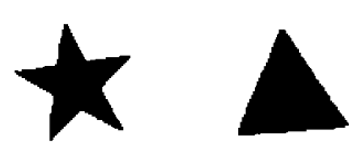


take care to download the set to your drive and update the path.

Plese follow this structure to store the dataset:

sets
> training_set
>> Class_0  
>> Class_1

> test_set
>> Class_0  
>> Class_1


Full Kaggle dataset:  
https://www.kaggle.com/datasets/smeschke/four-shapes

In [ ]:
#@title ####DATASET PATH
%%capture

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Correct the path for your Drive
train_data_path = '/content/drive/MyDrive/colab_notebooks/colab_set/colab_train'
test_data_path = '/content/drive/MyDrive/colab_notebooks/colab_set/colab_test'

We now exploit Data Augmentation techniques to extend the original dataset. In particular we apply rotations and exposure change only as the set is b/w.

Finally we remap all images to 500x500 px to equalize the input to the network.

In [ ]:
#@title ####IMAGE LOADING & PROCESSING

%%capture
# Define transformatins for Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = ImageFolder(train_data_path, transform=train_transform)
test_dataset = ImageFolder(test_data_path, transform=test_transform)

# Built the DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Loading, Training and Testing ResNet18

We now load the resnet18 network and praparate the last layer for binary classification.

ResNet18 Modified for Binary Classification:  

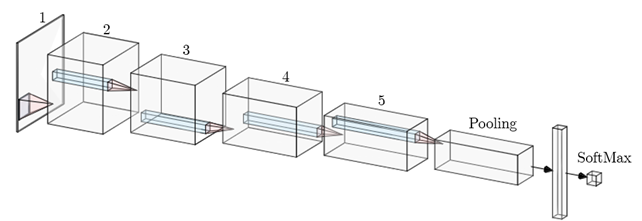

Recap:  
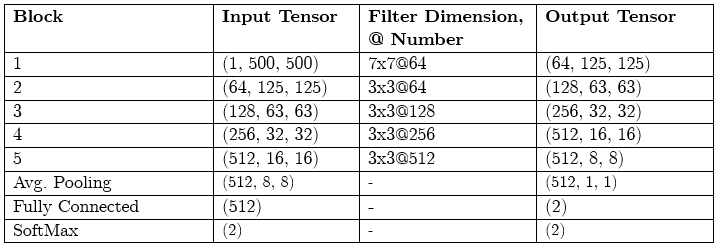

In [ ]:
#@title ####LOAD & MODIFY RESNET18

# Load ResNet18
pretrained = 'True'

if pretrained == 'False':
   resnet = models.resnet18()
   num_ftrs = resnet.fc.in_features
   resnet.fc = nn.Linear(num_ftrs, 2)
   nn.init.xavier_uniform_(resnet.fc.weight)
   nn.init.zeros_(resnet.fc.bias)
else:
  resnet = models.resnet18(pretrained=True) #future torchvision versions may require:  resnet = models.ResNet18_Weights.DEFAULT
  num_ftrs = resnet.fc.in_features
  resnet.fc = nn.Linear(num_ftrs, 2)

# Add a Softmax layer at the end
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Softmax(dim=1)
)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)
# Choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In this section we perform network training and subsequent testing.

In [ ]:
#@title ####TRAIN THE NETWORK

num_epochs = 3  # This is sufficent due to the triviality of the task
for epoch in range(num_epochs):
    resnet.train()
    total_train_correct = 0
    total_train_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * total_train_correct / total_train_samples

    resnet.eval()
    total_test_correct = 0
    total_test_samples = 0
    all_predicted_labels = []
    all_true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels).sum().item()

            all_predicted_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * total_test_correct / total_test_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {train_accuracy:.2f}% - Test Accuracy: {test_accuracy:.2f}%")



Epoch [1/3] - Train Accuracy: 99.35% - Test Accuracy: 100.00%
Epoch [2/3] - Train Accuracy: 100.00% - Test Accuracy: 100.00%
Epoch [3/3] - Train Accuracy: 100.00% - Test Accuracy: 100.00%


# Performance Analysis

Now we analyze performance in classification by exploring the confusion matrix, it is a matrix where false positives and false negatives are highlighted.

Confusion Matrix:
[[101   0]
 [  0 101]]


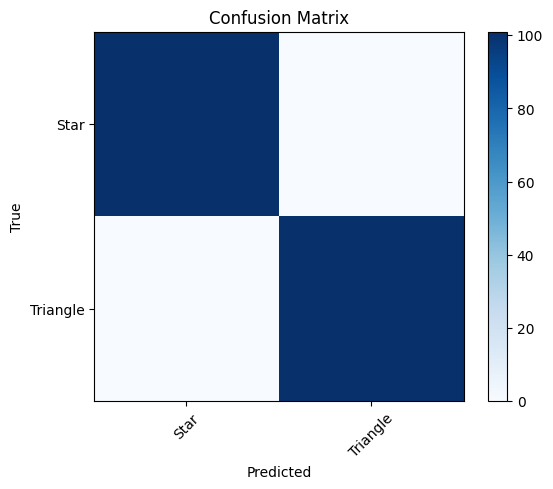

In [ ]:
#@title ####CONFUSION MATRIX (TEST)

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)

print("Confusion Matrix:")
print(confusion_mtx)

classes = ['Star', 'Triangle']
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

We conclude with an analysis of some metrics:

Precision and Recall:  
https://en.wikipedia.org/wiki/Precision_and_recall

F1:  
https://en.wikipedia.org/wiki/F-score



In [ ]:
#@title ####F1-SCORE (TEST)

from sklearn.metrics import precision_score, recall_score, f1_score

# Metrics for "Star" (label 0)
precision_star = precision_score(all_true_labels, all_predicted_labels, pos_label=0)
recall_star = recall_score(all_true_labels, all_predicted_labels, pos_label=0)
f1_star = f1_score(all_true_labels, all_predicted_labels, pos_label=0)

# Metrics for "Triangle" (label 1)
precision_triangle = precision_score(all_true_labels, all_predicted_labels, pos_label=1)
recall_triangle = recall_score(all_true_labels, all_predicted_labels, pos_label=1)
f1_triangle = f1_score(all_true_labels, all_predicted_labels, pos_label=1)

print("Metrics for Star class:")
print(f"Precision: {precision_star:.2f}")
print(f"Recall: {recall_star:.2f}")
print(f"F1-score: {f1_star:.2f}")

print("\nMetrics for Triangle class:")
print(f"Precision: {precision_triangle:.2f}")
print(f"Recall: {recall_triangle:.2f}")
print(f"F1-score: {f1_triangle:.2f}")

Metrics for Star class:
Precision: 1.00
Recall: 1.00
F1-score: 1.00

Metrics for Triangle class:
Precision: 1.00
Recall: 1.00
F1-score: 1.00


Here you can save the model if the results obtained are in line with expectations or you can simply re-train the network by varying the number of epochs, the initialization, the optimizer or the loss metrics.

In [ ]:
#@title ####EXPORT MODEL

# Salve the model in your Drive Folder
torch.save(resnet, '/content/drive/MyDrive/colab_notebooks/ResNet_binaryclass.pth')
print("Model Saved.")

Model Saved.


# Make New Clasification with the Trained Model

This part of code is independent of the previous blocks and can be executed as long as it has:

*   Trained model (ResNet_binaryclass.pth) loaded on Drive
*   New samples to classify also loaded on Drive

In this section the new sample must follow this organization in the folder:

set
> newclass_set
>> Image0   
>> Image1  
>> Image2    
>> ...




In [ ]:
#@title ####LOAD MODEL FROM DRIVE

# Define the path to the folder with images to classify on your Google Drive
to_classify_data_path = '/content/drive/MyDrive/colab_notebooks/colab_set/colab_newclass'
# Load the pretrained model from your Google Drive
model_path = '/content/drive/MyDrive/colab_notebooks/ResNet_binaryclass.pth'

In [ ]:
#@title ####RUN NEW INFERNCE PROCESS

import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

# Transformation consistent with the training and testing phase
test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
    transforms.ToTensor(),
])

# Create a custom dataset to load images directly
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, img_name  # Also return the image name

# Load the custom dataset
to_classify_dataset = CustomImageDataset(to_classify_data_path, transform=test_transform)

# Create the DataLoader
to_classify_loader = DataLoader(to_classify_dataset, batch_size=1, shuffle=False)

# Load the entire model, including additional layers
loaded_model = torch.load(model_path)
loaded_model.eval()

# Add the Softmax layer
softmax = nn.Softmax(dim=1)

# Define a dictionary to map class indices to class names
class_names = {
    0: 'Star',
    1: 'Triangle'
}

# Classify new images
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images, image_paths in to_classify_loader:  # Include image names in the loop
        images = images.to(device)
        outputs = loaded_model(images)
        probabilities = softmax(outputs)  # Apply Softmax to logits
        _, predicted = torch.max(probabilities, 1)

        image_name = os.path.basename(image_paths[0])  # Extract the image name from the list
        class_label = class_names[predicted.item()]  # Map index to class name

        results.append([image_name, class_label])

# Create a DataFrame with the results
result_matrix = pd.DataFrame(results, columns=['Image Name', 'Classification'])
print(result_matrix)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
    Image Name Classification
0     3671.png           Star
1     3687.png           Star
2     3703.png           Star
3     3663.png           Star
4     3695.png           Star
..         ...            ...
120    959.png       Triangle
121    999.png       Triangle
122    979.png       Triangle
123    989.png       Triangle
124     99.png       Triangle

[125 rows x 2 columns]
